<a href="https://colab.research.google.com/github/shizuo-kaji/TutorialTopologicalDataAnalysis/blob/master/TopologicalDataAnalysisWithPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tools for Topological Data Analysis
In this notebook, we will see
- What TDA offers for practitioners (Dimensionality reduction, Visualisation, Feature extraction, etc.)
- What types of input each method accepts (Point cloud, Image, Time series)
- How different tools can be used in coordination
- Some seeds for new research directions

This notebook is written by Shizuo KAJI
and maintained [here](https://github.com/shizuo-kaji/TutorialTopologicalDataAnalysis).

In [1]:
## If your system do not have the necessary libraries, run this cell to install them.
# Be patient! It may take a few minutes.
## If you are running this notebook locally, to install standard libraries such as numpy, scipy, scikit-learn
## The package manager "conda" may be better than "pip".
# For example, "conda install scikit-learn"
!pip install -q ripser umap-learn kmapper persim PersistenceImages
!pip install -q cripser
!pip install -q tomaster Boruta gudhi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.0/161.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 845.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.0 MB/s eta 0:00:00


In [2]:
## load necessary libraries
%matplotlib inline
# standard libraries
import numpy as np
import scipy as sp
import pandas as pd
import glob,os,re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# image related libraries
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt,convolve
import seaborn as sns
import skimage
from skimage import io
from PIL import Image
# TDA related libraries
import cripser, tcripser
from ripser import ripser
import persim
import gudhi

### define functions used later

# gaussian kernel for convolution
def gaussian(h,sigma):
    x = np.arange(-h[0],h[0],1)
    y = np.arange(-h[1],h[1],1)
    z = np.arange(-h[2],h[2],1)
    xx, yy,zz = np.meshgrid(x,y,z)
    return(np.exp(-(xx**2 + yy**2 + zz**2)/(2*sigma**2)).astype(np.float32))

# computing the heatmap of cycles with specified birth-death properties
# the heatmap image reveals what kind of image features are captured by PH
def heat_map(img,pd,h=3,sigma=1,min_life = 10,max_life =255,min_birth = 0,max_birth = 255,dimension = 0,life_weighted=True,location='birth'):
  if len(img.shape)==2:
    mx,my=img.shape
    mz = 1
    kernel = gaussian([h,h,1],sigma)
  else:
    mx,my,mz=img.shape
    kernel = gaussian([h,h,h],sigma)

  selected_cycle = np.zeros((mx,my,mz))
  ppd = pd[pd[:,0] == dimension]
  ppd = ppd[min_life < ppd[:,2]-ppd[:,1]]
  ppd = ppd[ppd[:,2]-ppd[:,1] < max_life]
  ppd = ppd[min_birth < ppd[:,1]]
  ppd = ppd[ppd[:,1] < max_birth]
  w = 1
  for c in ppd:
      if location=='birth':
        x,y,z=int(c[3]),int(c[4]),int(c[5])
      else:
        x,y,z=int(c[6]),int(c[7]),int(c[8])
      if life_weighted:
        w = c[2]-c[1]
      #selected_cycle[max(0,x-h):min(mx,x+h),max(0,y-h):min(my,y+h),max(0,z-h):min(mz,z+h)] += w
      selected_cycle[x,y,z] += w
  #print(np.min(selected_cycle),np.max(selected_cycle),np.sum(selected_cycle))
  cycle_conv = convolve(selected_cycle,kernel)
  #print(np.min(cycle_conv),np.max(cycle_conv),np.sum(cycle_conv))
  return(np.squeeze(cycle_conv))

# slice viewer for a 3D image
def explore_slices(data, cmap="gray"):
    from ipywidgets import interact
    N = data.shape[-1]
    @interact(plane=(0, N - 1))
    def display_slice(plane=N//2):
        fig, ax = plt.subplots(figsize=(20, 5))
        plt.imshow(data[:,:,plane], cmap=cmap)
        plt.show()
    return display_slice

# make binary and apply distance transform
def dt(img,radius=None,signed=False):
    if radius is not None:
      from skimage.filters import rank
      from skimage.morphology import disk, ball
      bw_img = (img >= rank.otsu(img, disk(radius)))
    else:
      bw_img = (img >= threshold_otsu(img))
    dt_img = distance_transform_edt(bw_img)
    if signed:
        dt_img -= distance_transform_edt(~bw_img)
    return(dt_img)


In [3]:
## Here's an example how to manage files on Google Colab
# Alternatively, you can simply use the "Files" tab on the left to download/upload files.

#!ls
#from google.colab import files
#uploaded = files.upload()
#files.download('kepler-mapper-output.html')


## Feature extraction from different data types

As a simplest application of Persistent Homology (PH), PH can be used to assign a feature vector to data.

### Point cloud

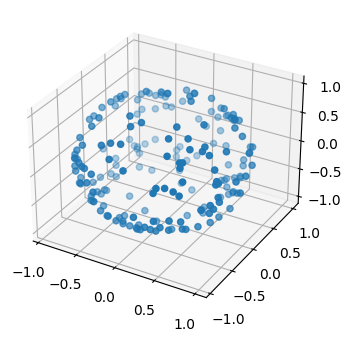

In [ ]:
## create random data on 2-sphere
X = np.random.rand(200,3)-0.5  # 200 random points in [-0.5,0.5]^3
X = X / np.sqrt(np.sum(X**2,axis=1,keepdims=True)) # normalize to have the unit length
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])

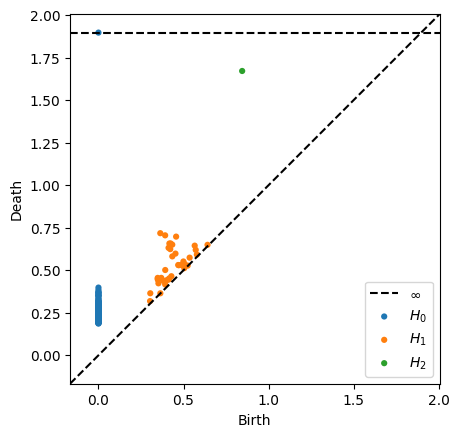

In [ ]:
## compute persistent homology (PH) of the Vietoris-Rips (VR) complex and plot the persistence diagram (PD)
## VR-complex has a huge number of simplices. So the maximum number of points that is tractable is in the order of 1000.
## To reduce the computational complexity, you can compute an approximated PH by setting, e.g., "n_perm=100" (sub-sampling 100 points which are far apart).
diag = ripser(X,maxdim=2,n_perm=100)['dgms']
persim.plot_diagrams(diag)

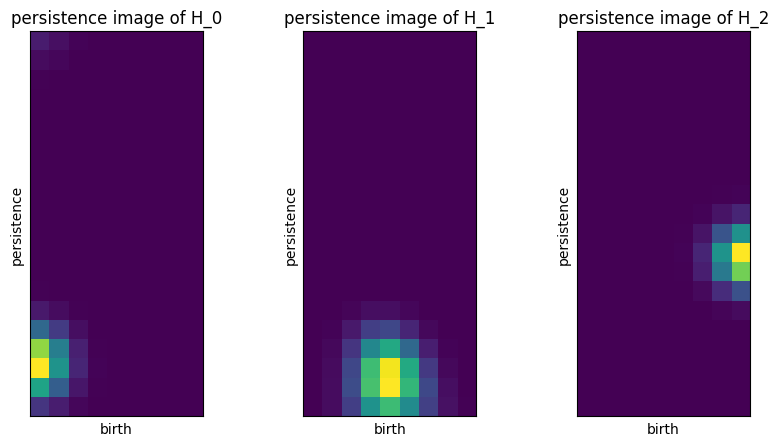

In [ ]:
# plot PD with Persistence Image
# look at https://persim.scikit-tda.org/en/latest/reference/stubs/persim.PersistenceImager.html for weighting options
min_birth, max_death = 0,2
dclip = [np.clip(d,min_birth, max_death) for d in diag]
pimgr = persim.PersistenceImager(pixel_size=0.1, kernel_params={'sigma': [[0.01, 0.0], [0.0, 0.01]]})
pimgr.fit(dclip, skew=True)
pimgs = pimgr.transform(dclip, skew=True,n_jobs=-1)

plt.figure(figsize=(10,5))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    pimgr.plot_image(pimgs[i], ax)
    plt.title("persistence image of H_{}".format(i))


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

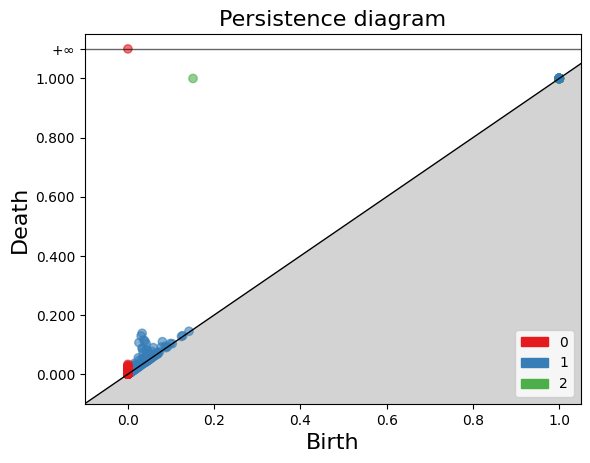

In [ ]:
## from a point cloud, we can construct different complexes.
# The choice affects performance and the result, so we have to give a careful consideration
# Let's see an example of alpha complex.

simplex_tree = gudhi.AlphaComplex(points=X).create_simplex_tree()
diag = simplex_tree.persistence()

# We observe a notable difference in H_1 compared to the result of the VR complex above
gudhi.plot_persistence_diagram(diag, legend=True)

#!pip install cechmate  ## C++ compilers are required on the system
#import cechmate as cm
#alpha = cm.Alpha()
#filtration = alpha.build(X)
#dgmsalpha = alpha.diagrams(filtration)
#persim.plot_diagrams(dgmsalpha)

### Distance between persistent diagrams
- classification/visualisation example

In [ ]:
# sampling points from sphere and cube
def sample_sphere(n,radius=1):
    X = np.random.rand(n,3)-0.5
    X = X / np.sqrt(np.sum(X**2,axis=1,keepdims=True))
    X *= radius
    X += np.random.normal(scale=0.2,size=(len(X),3))
    X += np.random.uniform(-1,1,3)
    return(X)
def sample_cube(n,radius=1):
    X = 2*np.random.rand(n,3)-1
    X *= radius
    X += np.random.uniform(-1,1,3)
    return(X)


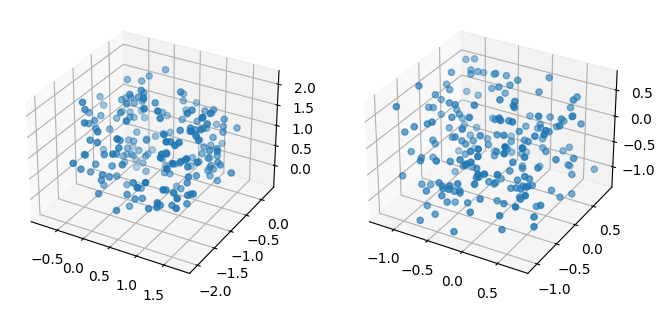

In [ ]:
## create point clouds from sphere and cube and compute pairwise bottleneck distance of PH
n=5   # number of spheres (cubes). In total, we'll have 2n sets of point clouds.
X=[sample_sphere(200) for i in range(n)]
Y=[0]*n
X.extend([sample_cube(200) for i in range(n)])
Y.extend([1]*n)

## Plot the point clouds: for human eyes, it is not very easy to distinguish 3d point clouds
# sphere
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[0][:, 0], X[0][:, 1], X[0][:, 2])
# cube
ax = fig.add_subplot(122, projection='3d')
ax.scatter(X[n][:, 0], X[n][:, 1], X[n][:, 2])

# compute PH and distance
pd = []
for i in range(2*n):
    pd.append(ripser(X[i],maxdim=2,n_perm=100)['dgms'][2])

D = np.zeros((2*n,2*n))
for i in range(2*n-1):
    for j in range(i+1,2*n):
        D[i,j]=persim.bottleneck(pd[i], pd[j])


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


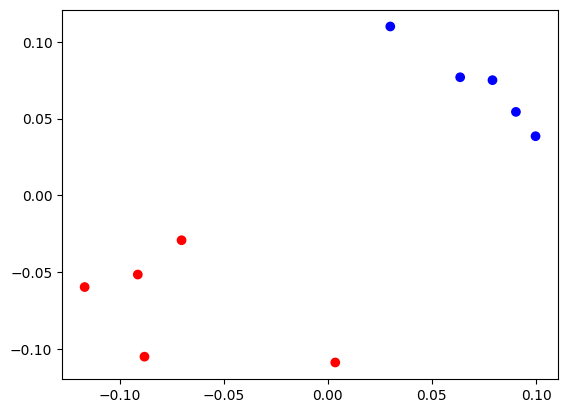

In [ ]:
## Bottleneck distance discern spheres from cubes
# We obtain the distance matrix for point clouds, and thus, a finite metric space with 2n points.
# For visualisation, we use Multi-dimensional scaling, a method to embed a finite metric space into a Euclidean space
# Blue dots represent cubes, red dots represent spheres
from sklearn.manifold import MDS
mds = MDS(n_components=2,dissimilarity='precomputed')
D = D+D.T
X_mds = mds.fit_transform(D)
col = ['r','b']
plt.scatter(X_mds[:,0],X_mds[:,1],c=[col[y] for y in Y])

Distances
Bottleneck (GUDHI-hera) with L-infty metric: 6.499999999999999
Bottleneck (persim) with L-infty metric: 6.5
2-Wasserstein (GUDHI-hera) with L-infty metric: 12.504999999999999
2-Wasserstein (GUDHI-hera) with L2 Euclidean metric: 17.684740597475553
99-Wasserstein (GUDHI-hera) with L2 Euclidean metric: 9.192421749823405
99-Wasserstein (GUDHI-hera) with L-infty metric (approx. Bottleneck distance): 6.500023754826838


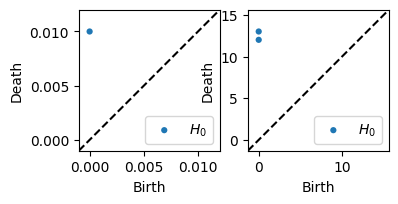

In [ ]:
## Remark on Bottleneck and p-Wasserstein distances
# We have two parameters for Wasserstein distance: the exponent p and the metric for the underlying space.
import gudhi,gudhi.hera,gudhi.wasserstein,persim
X,Y =np.array([[0., 0.01]]), np.array([[0., 13.],[0.,12.]])
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(121)
persim.plot_diagrams(X, ax=ax)
ax = fig.add_subplot(122)
persim.plot_diagrams(Y, ax=ax)

print("Distances")
print("Bottleneck (GUDHI-hera) with L-infty metric:", gudhi.bottleneck_distance(X,Y))
print("Bottleneck (persim) with L-infty metric:", persim.bottleneck(X,Y))
#print(gudhi.wasserstein.wasserstein_distance(X, Y, order=1, internal_p=2)) ## requires pot
print("2-Wasserstein (GUDHI-hera) with L-infty metric:", gudhi.hera.wasserstein_distance(X, Y, order=1, internal_p=np.inf))
print("2-Wasserstein (GUDHI-hera) with L2 Euclidean metric:", gudhi.hera.wasserstein_distance(X, Y, order=1, internal_p=2))
print("99-Wasserstein (GUDHI-hera) with L2 Euclidean metric:", gudhi.hera.wasserstein_distance(X, Y, order=99, internal_p=2))
print("99-Wasserstein (GUDHI-hera) with L-infty metric (approx. Bottleneck distance):", gudhi.hera.wasserstein_distance(X, Y, order=99, internal_p=np.inf))



### point cloud in an ambient metric space

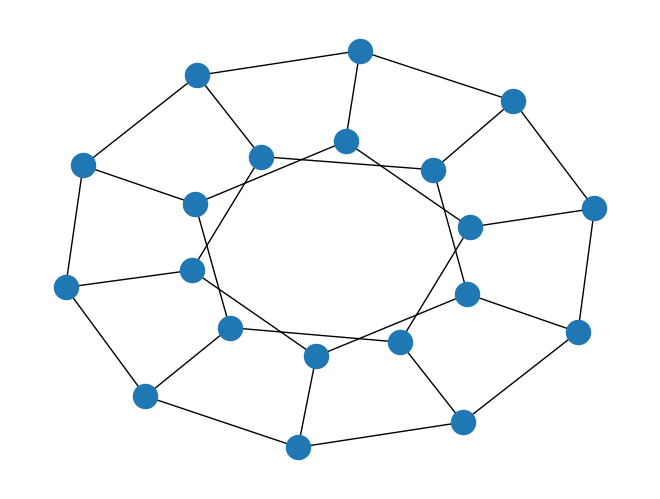

In [ ]:
## VR complex can also be constructed from an abstract distance matrix, not necessaliry from a point cloud in a Euclidean space.
# We give an example of a graph distance
import networkx as nx
G=nx.dodecahedral_graph()
nx.draw(G)
D=np.array(nx.floyd_warshall_numpy(G)) # distance matrix


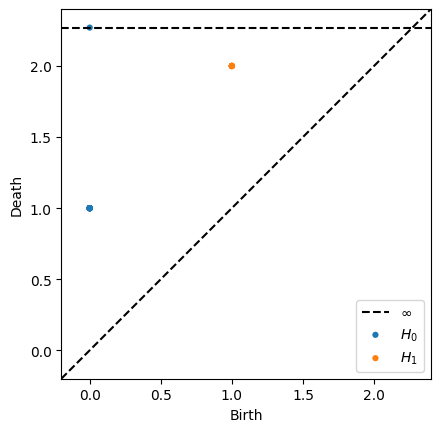

In [ ]:
# compute persistence of a distance matrix
diag = ripser(D,distance_matrix=True)['dgms']
persim.plot_diagrams(diag)

# (A direction of new research) An interesting question is:
# for a set of point clouds (or images), we can first compute PD for each point cloud and then compute the distance matrix of PDs.
# PH of the distance matrix defines a feature for "a set of point clouds".
# Do we have a practical application?
# for example: we have multiple measurements for objects from each class, and each measurement yields PH.
# in this case, "PH of PD" provides a collective feature for the objects beloging to the class.

### Trajectory of cycles in a sequence of PD

(A direction of new research)
Tracking cycles over time should be done by looking at cycle representatives.
However, a quick-and-dirty way is to use the matching used in the Wasserstein distance (optimal transport).
We demonstrate this method with a series of PDs of computed from a series of point clouds.


In [ ]:
# sample from Figure 8
def create_figure8(num_samples=200):
  t = np.linspace(0, 2*np.pi, num=num_samples)
  X = np.stack((np.sqrt(2)*np.cos(t) / (np.sin(t)**2+1), np.sqrt(2)*np.cos(t)*np.sin(t) / (np.sin(t)**2+1))).T
  X += 0.1*np.random.random(X.shape)
  return(X)

In [ ]:
# create a sequence of figure8 with varying scale
# and compute their PD
Xs = []
diags = []
frames = 30
for fr in range(frames):
  a = frames/2
  X = create_figure8() * (a**2-(fr-a)**2)/(a**2)
  Xs.append(X)
  diags.append(ripser(Xs[fr],maxdim=1,n_perm=100)['dgms'])

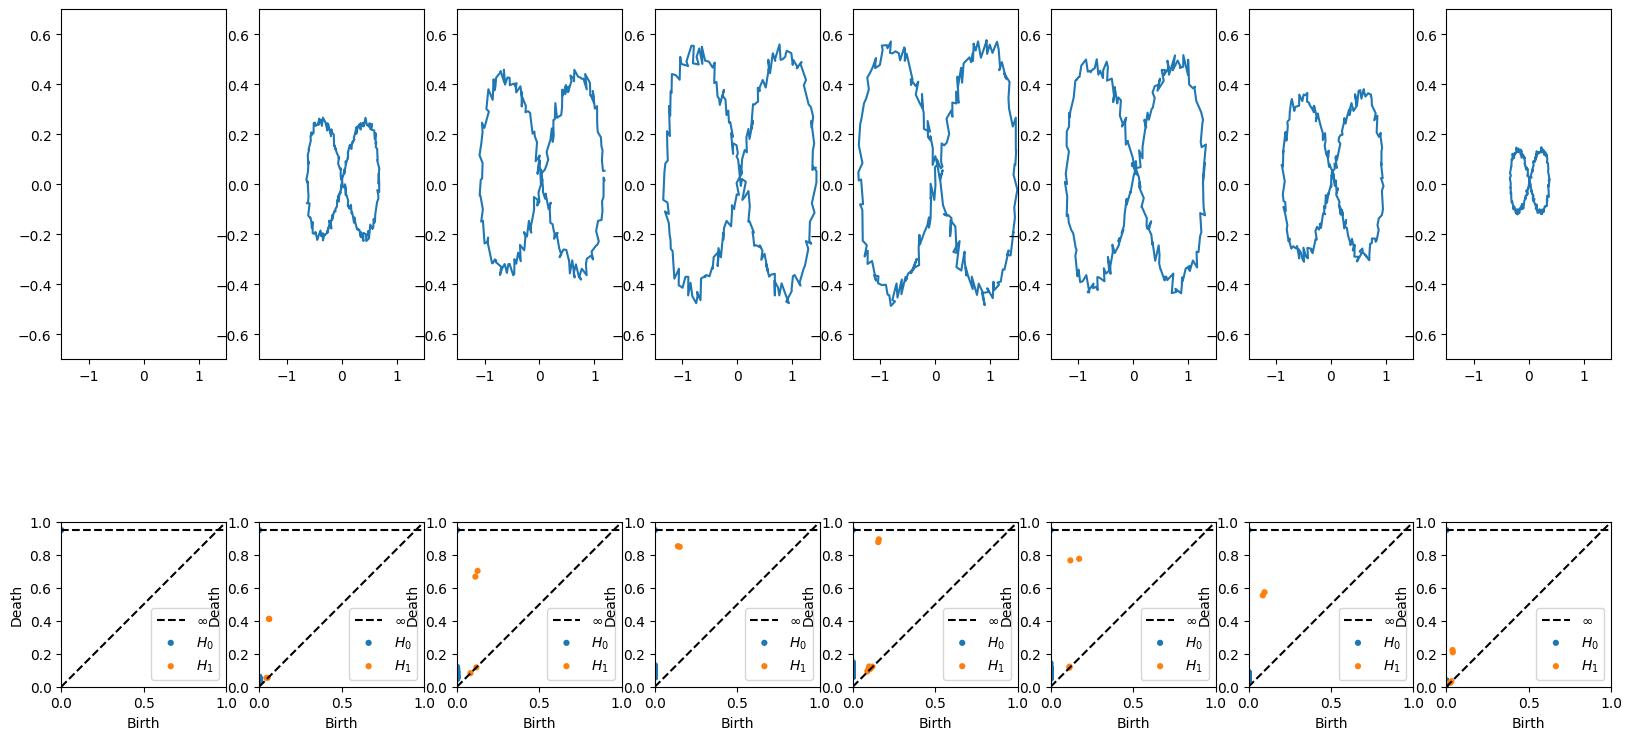

In [ ]:
# plot some of the samples
from mpl_toolkits.axes_grid1 import ImageGrid
num_disp=7
fig = plt.figure(figsize=(20, 10))
i=0
for x,dg in zip(Xs[::(len(Xs)//num_disp)],diags[::(len(Xs)//num_disp)]):
    un = len(Xs[::(len(Xs)//num_disp)])
    ax = fig.add_subplot(2,un,i+1)
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-0.7,0.7)
    ax.plot(*x.T)
    persim.plot_diagrams(dg,xy_range=(0,1,0,1),ax=fig.add_subplot(2,un,i+1+un))
    i=i+1

In [ ]:
# match cycles between adjacent frames and plot their trajectories
import matplotlib.colors as colors
import matplotlib.cm as cm
def cycle_trajectory(diags,dim):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  plt.xlim(0,0.3)
  plt.ylim(0,1)
  usercmap = plt.get_cmap('jet')
  cNorm  = colors.Normalize(vmin=0, vmax=len(diags))
  scalarMap = cm.ScalarMappable(norm=cNorm, cmap=usercmap)
  for i in range(len(diags)-1):
    D1 = diags[i][dim]
    D2 = diags[i+1][dim]
    d, M= persim.wasserstein(D1,D2,matching=True)
    for m in M:
      m0 = int(m[0]) # matched ids
      m1 = int(m[1])
      if -1<m0<len(D1) and -1<m1<len(D2):
        plt.plot( [D1[m0][0], D2[m1][0]],[D1[m0][1], D2[m1][1]],  'k-', lw=1)
#        plt.plot(*D1[m0],'ko')
        plt.plot(*D2[m1],'o',color = scalarMap.to_rgba(i))
  plt.colorbar(scalarMap, label="time")
  plt.xlabel("birth")
  plt.ylabel("life")
  plt.show()

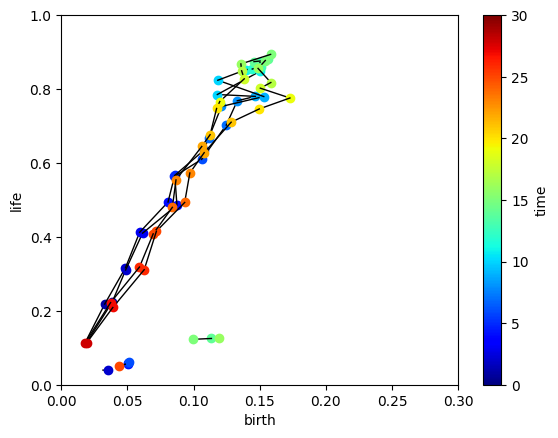

In [ ]:
## visualise H_1 trajectory
# blue: early frame => red: late frame
# we can observe that two cycles emerge and grow (to longer lifetime) and then follow the path back to finally disapear.
# the points with low lifetime are noise
cycle_trajectory(diags,dim=1)

### Image

[dim,birth,death,x1,y1,z1,x2,y2,z2]
[[0 0 1 3 0 0 3 1 0]
 [0 0 9 3 4 0 0 0 0]
 [1 1 2 1 2 0 1 3 0]]


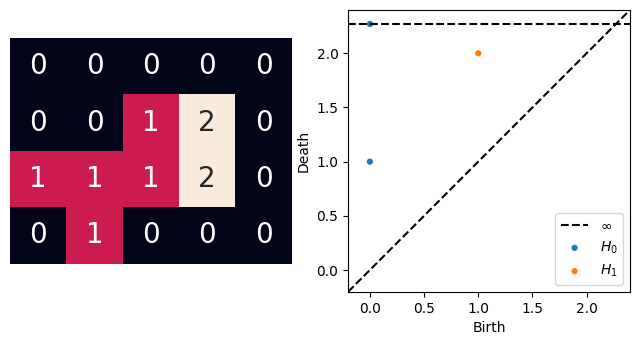

In [ ]:
## simple example
import cripser, tcripser
import persim

# define a 2D array
simple_img=np.array([[0,0,0,0,0],
                      [0,0,1,2,0],
                      [1,1,1,2,0],
                      [0,1,0,0,0]])

# plot the array
fig,axs = plt.subplots(1,2,figsize=(8,4))
sns.heatmap(simple_img, annot=True, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":20}, cbar=False, ax=axs[0])

# compute PH of the 2D array (the V-construction)
pdt = cripser.computePH(simple_img)

# each line contains (dim,birth,death,x1,y1,z1,x2,y2,z2), where (x1,y1,z1) is the location of the creator cell of the cycle and (x2,y2,z2) is the location of the destroyer cell of the cycle"
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]")
print(np.where(pdt<9, pdt, 9).astype(int)) # replace infty with 9 for printing

# plot persistence diagram
persim.plot_diagrams([p[:,1:3] for p in [pdt[pdt[:,0] == i] for i in range(2)]], ax=axs[1])


<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


[dim,birth,death,x1,y1,z1,x2,y2,z2]
[[ 0 -2 -1  3  3  0  2  3  0]
 [ 0 -1  1  0  0  0  1  0  0]
 [ 0 -3  9  0  6  0  0  0  0]]


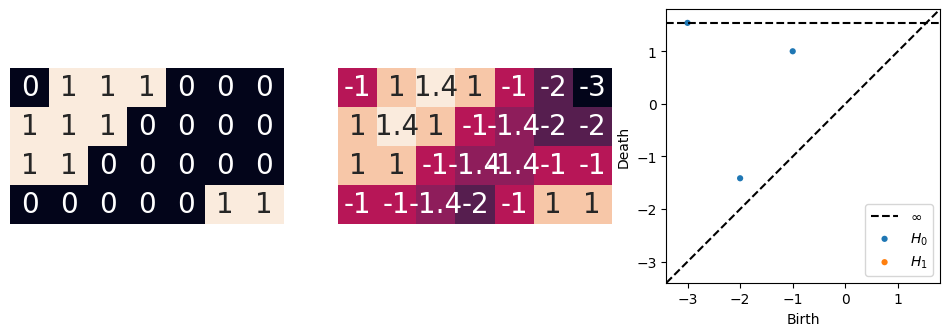

In [7]:
## simple example with distance transform
# define a binary 2D array
simple_img=np.array([[0,1,1,1,0,0,0],
                      [1,1,1,0,0,0,0],
                      [1,1,0,0,0,0,0],
                      [0,0,0,0,0,1,1]],dtype=bool)

# apply distance transform
dt_img = dt(simple_img,signed=True)

# plot the array
fig,axs = plt.subplots(1,3,figsize=(12,4))
sns.heatmap(simple_img, annot=True, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":20}, cbar=False, ax=axs[0])
sns.heatmap(dt_img, annot=True, square=True, yticklabels=False, xticklabels=False, annot_kws={"fontsize":20}, cbar=False, ax=axs[1])

# compute PH of the 2D array (the V-construction)
pdt = cripser.computePH(dt_img)

# each line contains (dim,birth,death,x1,y1,z1,x2,y2,z2), where (x1,y1,z1) is the location of the creator cell of the cycle and (x2,y2,z2) is the location of the destroyer cell of the cycle"
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]")
print(np.where(pdt<9, pdt, 9).astype(int)) # replace infty with 9 for printing

# plot persistence diagram
persim.plot_diagrams([p[:,1:3] for p in [pdt[pdt[:,0] == i] for i in range(2)]], ax=axs[2])


0 255 uint8


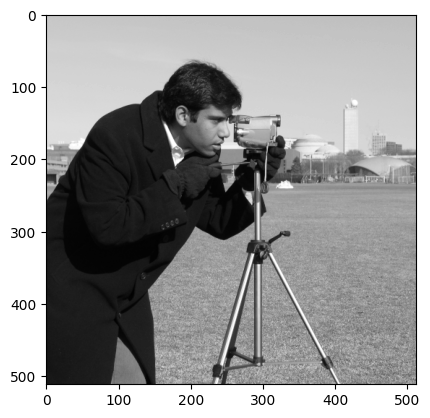

In [ ]:
# load a sample greyscale photo
img = skimage.data.camera()
## if you want to upload your own image to Google Colab
#from google.colab import files
#img = skimage.color.rgb2gray(io.imread(list(files.upload().keys())[0]))

# plot
plt.imshow(img, cmap='gray')
print(np.min(img),np.max(img),img.dtype)

[dim,birth,death,x1,y1,z1,x2,y2,z2]
[[  0.   2.   3. 304. 157.   0. 305. 158.   0.]
 [  0.   2.   3. 306. 157.   0. 313. 154.   0.]
 [  0.   2.   3. 326. 152.   0. 327. 153.   0.]
 [  0.   2.   3. 322. 153.   0. 323. 153.   0.]
 [  0.   2.   3. 319. 153.   0. 320. 153.   0.]]
Betti numbers:  [22963, 13716]
Betti numbers:  [13563, 23286]


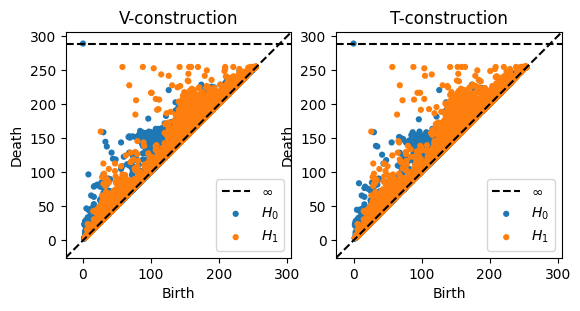

In [ ]:
# compute PH of the sublevel filtration
# V-construction of the original image (pixel value filtration)
pd = cripser.computePH(img,maxdim=1)

# each line contains (dim,birth,death,x1,y1,z1,x2,y2,z2), where (x1,y1,z1) is the location of the creator cell of the cycle and (x2,y2,z2) is the location of the destroyer cell of the cycle"
print("[dim,birth,death,x1,y1,z1,x2,y2,z2]")
print(pd[:5])

# arrange degree-wise
pds = [pd[pd[:,0] == i] for i in range(2)]
print("Betti numbers: ",[len(pds[i]) for i in range(len(pds))])

# T-construction of the original image (pixel value filtration)
pdt = tcripser.computePH(img,maxdim=1)
pdst = [pdt[pdt[:,0] == i] for i in range(2)]
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])

## plot persistent diagram using persim
fig,axs = plt.subplots(1,2)
persim.plot_diagrams([p[:,1:3] for p in pds], ax=axs[0], title='V-construction')
persim.plot_diagrams([p[:,1:3] for p in pdst], ax=axs[1], title='T-construction')


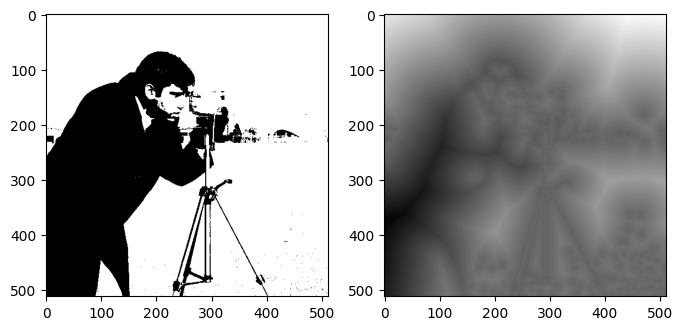

In [ ]:
## For greyscale images, we have another notion of persistence than the sublevel filtration
# the following function makes the input image binary and apply distance transform
# the sublevel filtration is suitable when pixel values have significant meaning in your data (like the HU value in CT)
# while the distance transform is suitable when you are interested in the scale of the geometric structure in your data.

from scipy.ndimage import distance_transform_edt
from skimage.filters import threshold_otsu
bw_img = (img >= threshold_otsu(img)) # binarise by Otsu's method
dt_img = dt(img,signed=True)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(bw_img,cmap='gray')
ax = fig.add_subplot(122)
ax.imshow(dt_img, cmap='gray')

Betti numbers:  [717, 311]
Betti numbers:  [393, 725]


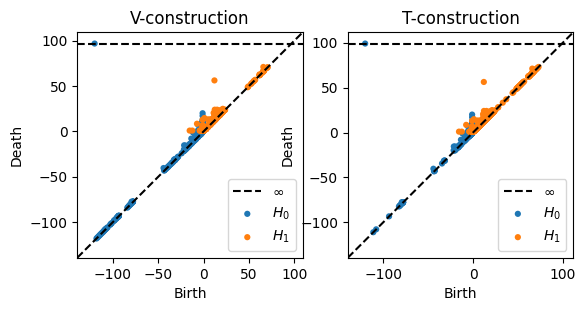

In [ ]:
# compute persistence of the distance transform
# V-construction of the distance transformed image
pd = cripser.computePH(dt_img)
pds = [pd[pd[:,0] == i] for i in range(2)]
print("Betti numbers: ",[len(pds[i]) for i in range(len(pds))])

# T-construction of the distance transformed image
pdt = tcripser.computePH(dt_img)
pdst = [pdt[pdt[:,0] == i] for i in range(2)]
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])

## plot persistent diagram using persim
fig,axs = plt.subplots(1,2)
persim.plot_diagrams([p[:,1:3] for p in pds], ax=axs[0], title='V-construction')
persim.plot_diagrams([p[:,1:3] for p in pdst], ax=axs[1], title='T-construction')


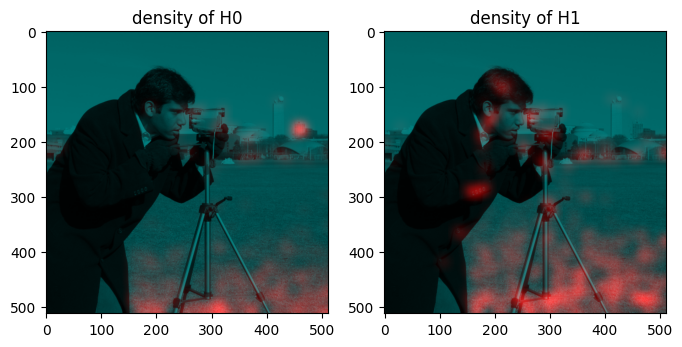

In [ ]:
## Plot heatmap for H_0 and H_1
# the density of the birth locations of the cycles are shown

pd = cripser.computePH(img,maxdim=1)
fig = plt.figure(figsize=(8, 4))
for i in range(2):
  heat=heat_map(img,pd,h=20,sigma=10,min_birth=10,min_life=30,dimension=i,location='birth')
  heat = (heat/np.max(heat) * 255).astype(np.uint8)
  ax = fig.add_subplot(1,2,i+1)
  ax.imshow(np.dstack([heat,img//2,img//2]))
  ax.set_title("density of H{}".format(i))


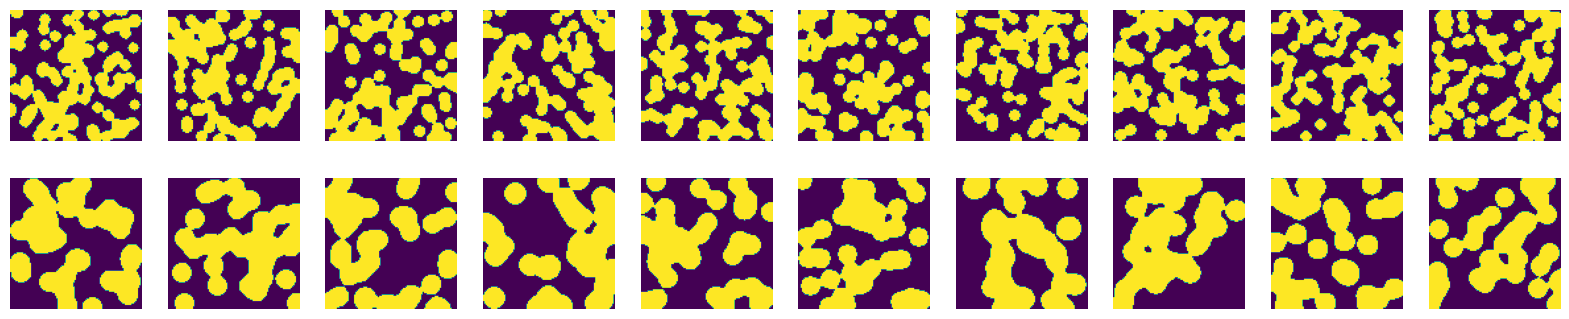

In [38]:
## Power of PH as a feature extractor depends on the problem
## Let us perform a classification task with a syhthetic dataset, where PH works well.

from skimage import data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

## create a binary classification problem consisting of random blobs of different size
n = 100
X = [data.binary_blobs(length=100, blob_size_fraction=0.1) for i in range(n)] # class A: small size
X.extend([data.binary_blobs(length=100, blob_size_fraction=0.15) for i in range(n)]) # class B: large size

# class label
Y = [0 for i in range(n)]
Y.extend([1 for i in range(n)])

# plot
fig,axs = plt.subplots(2,10,figsize=(20,4))
for i in range(10):
  axs[0,i].imshow(X[i])
  axs[1,i].imshow(X[i+n])
  axs[0,i].axis('off')
  axs[1,i].axis('off')


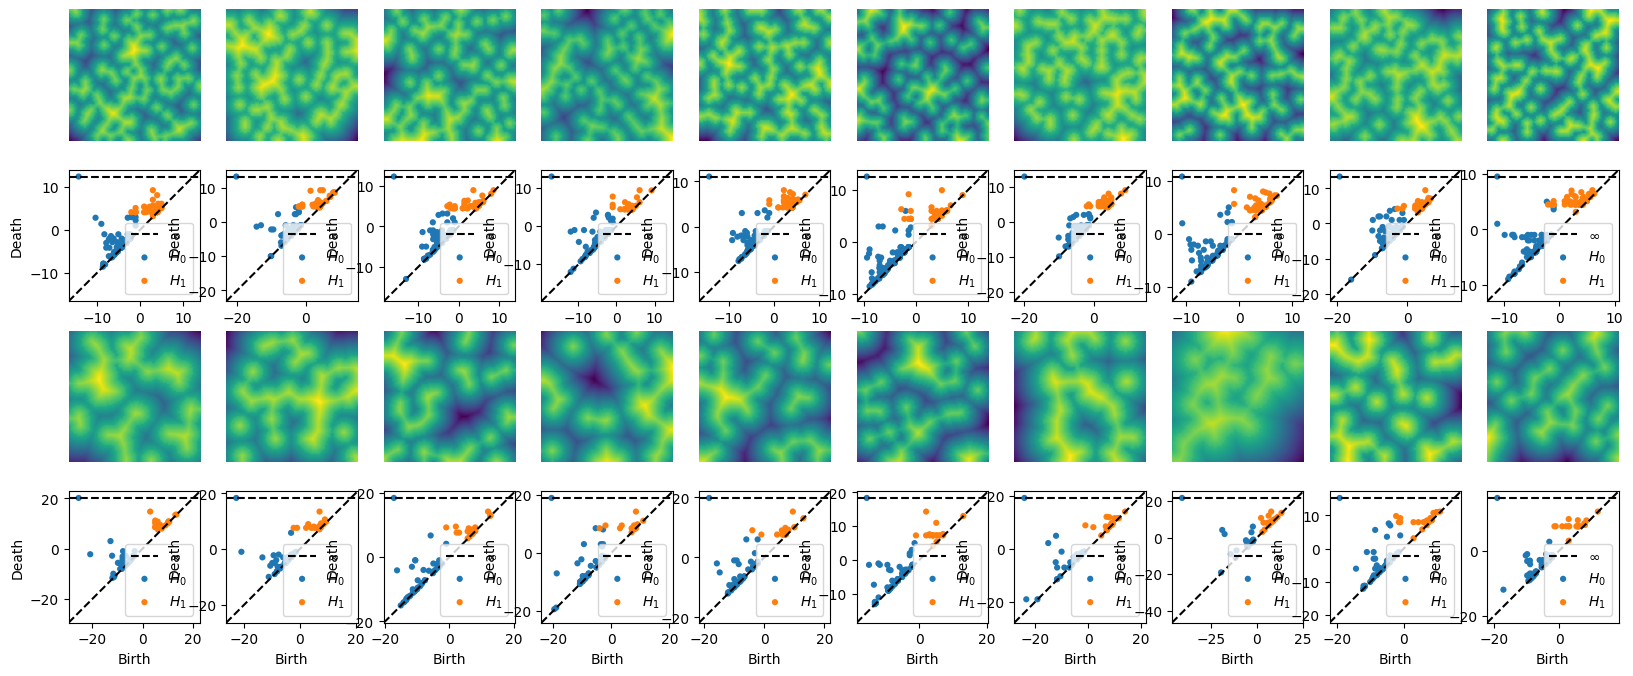

In [39]:
# since the size matters in this task, we apply distance transform to extract size information in PH
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

pds = []
for i in range(len(X)):
    pd = cripser.computePH(dt(X[i],signed=True))    # compute PH of distance transform
    pds.append(pd)

# plot some of them
fig,axs = plt.subplots(4,10,figsize=(20,8))
for i in range(10):
  axs[0,i].imshow(dt(X[i],signed=True))
  axs[0,i].axis('off')
  pd=pds[i]
  persim.plot_diagrams([p[:,1:3] for p in [pd[pd[:,0] == i] for i in range(2)]],ax = axs[1,i])
  axs[2,i].imshow(dt(X[i+n],signed=True))
  axs[2,i].axis('off')
  pd=pds[i+n]
  persim.plot_diagrams([p[:,1:3] for p in [pd[pd[:,0] == i] for i in range(2)]],ax = axs[3,i])

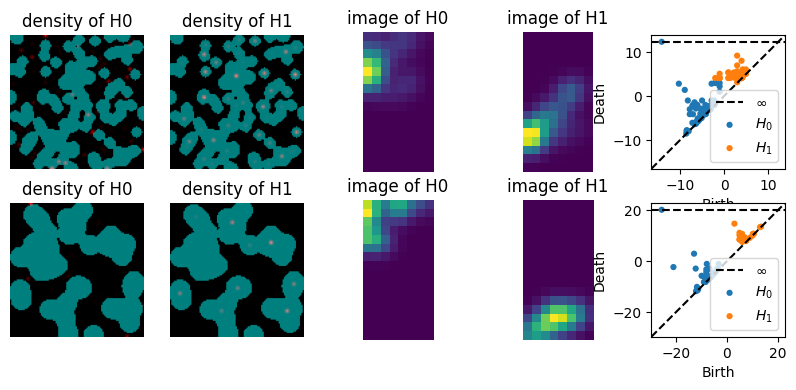

In [40]:
# plot some of the data
# in persistence image, x: lifetime, y: birth

import PersistenceImages.persistence_images as pimg
max_life = 8
pixel_size = 1
pim = pimg.PersistenceImager(birth_range=(-max_life,max_life), pers_range=(0,max_life), pixel_size=pixel_size)

idx = [0,n]
nn=len(idx)
fig,axs = plt.subplots(nn,5,figsize=(nn*5,4))
for i in range(nn):
  img = X[idx[i]]*255
  pd = pds[idx[i]]
  for d in range(2):
    heat=heat_map(img,pd,h=5,sigma=1,min_life=0,max_life=max_life,min_birth =-max_life,max_birth = max_life,dimension=d,location='death')
    heat = (heat/max(1,np.max(heat))*255).astype(np.uint8)
    axs[i,0+d].imshow(np.dstack([heat,img//2,img//2]))
    axs[i,0+d].set_title("density of H{}".format(d))
    axs[i,0+d].axis('off')
    axs[i,2+d].imshow(pim.transform(pd[pd[:,0]==d,1:3]))
    axs[i,2+d].set_title("image of H{}".format(d))
    axs[i,2+d].axis('off')
  persim.plot_diagrams([p[:,1:3] for p in [pd[pd[:,0] == i] for i in range(2)]],ax = axs[i,4])


In [41]:
### Feature extraction through persistence image
pims_h0, pims_h1 = [], []
for i in range(len(X)):
    pd = pds[i]
    pd[:,1:3] = np.clip(pd[:,1:3],a_min=-max_life,a_max=max_life) # clip min/max birth/death
    pim0 = pim.transform(pd[pd[:,0]==0,1:3]) # vectorise PH0 by persistence image
    pim1 = pim.transform(pd[pd[:,0]==1,1:3]) # vectorise PH1 by persistence image
    pims_h0.append(pim0.ravel())
    pims_h1.append(pim1.ravel())

## classification
(trainX, testX, trainY, testY) = train_test_split(pims_h1, Y, test_size = 0.3, random_state = 0, stratify=Y) # use PH1
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))


Confusion matrix
 [[30  0]
 [ 0 30]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



Important feature: birth around  -2.666666666666667 lifetime around  3.4285714285714284


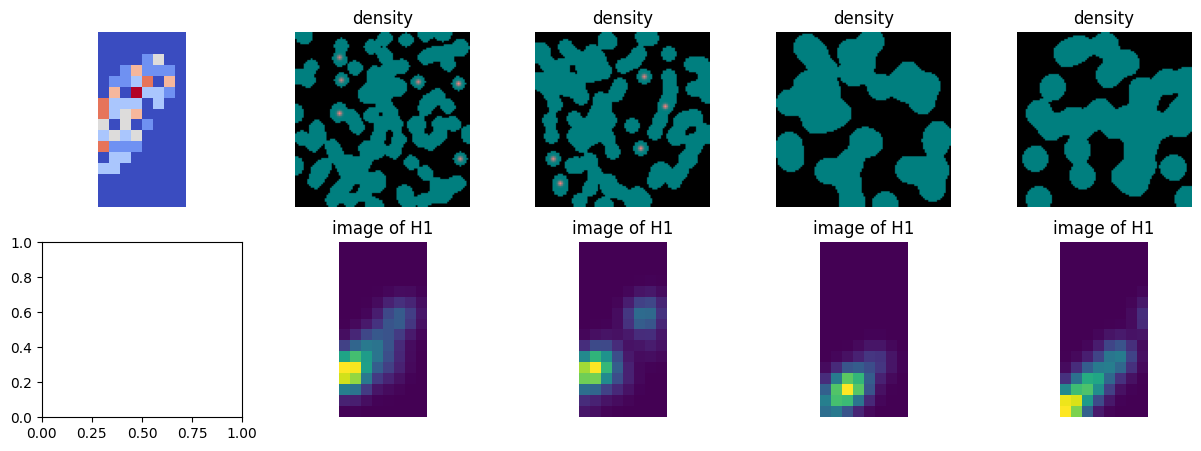

In [42]:
## identify what variables have impact on the decision
# in this case, the region of the persistence image of H1
# this kind of visualisation is useful for explaining results and seek for a mechanism behind the phenomena at hand.
indices = np.argsort(clf.feature_importances_)
#plt.barh(range(len(indices)), clf.feature_importances_[indices])

idx = [0,1,n,n+1]
nn = len(idx)

fig,axs = plt.subplots(2,nn+1,figsize=(3+nn*3,5))
axs[0,0].imshow(clf.feature_importances_.reshape(pim1.shape),cmap='coolwarm')
axs[0,0].axis('off')
most_important = np.unravel_index(indices[-1], shape=pim1.shape)
life,birth = np.meshgrid(np.linspace(0,max_life,pim1.shape[1]),np.linspace(-max_life,max_life,pim1.shape[0]))
b = birth[most_important]
l = life[most_important]
print("Important feature: birth around ", b,"lifetime around ", l)

# annotate the density of the most contributing feature on the image
# For demonstration, we pick one image from each class.
# the annotation explains how the classifier discerns two classes
for i in range(nn):
  img = X[idx[i]]*255
  pd = pds[idx[i]]
  h = 3*pixel_size
  heat=heat_map(img,pd,h=5,sigma=1,min_life=l-h,max_life=l+h,min_birth =b-h,max_birth = b+h,dimension=1,location='death')
  heat = (heat/max(1,np.max(heat))*255).astype(np.uint8)
  axs[0,i+1].imshow(np.dstack([heat,img//2,img//2]))
  axs[0,i+1].set_title("density")
  axs[0,i+1].axis('off')
  axs[1,i+1].imshow(pim.transform(pd[pd[:,0]==1,1:3]))
  axs[1,i+1].set_title("image of H{}".format(1))
  axs[1,i+1].axis('off')



### Volume

(256, 256, 12) float64 0.00434882124055848--0.9204089417868314


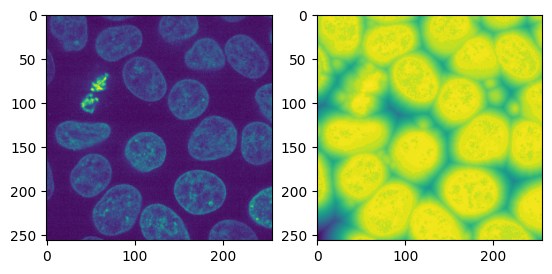

In [ ]:
## set the following appropriately
IMG_DIR = "./images/"  ## dir containing images for a 3D example; all the images must be of the same dimension

# create a 3d stack from 2d images
if os.path.isdir(IMG_DIR):
    from PIL import Image
    # load image files from a dir and stack into a 3D array of type float64
    input_files = os.path.join(IMG_DIR,"*.jpg")
    files = [f for f in glob.glob(input_files)]
    files.sort(key=lambda val : int(re.sub("\\D", "", val+"0")))
    img3d = np.dstack([Image.open(f).convert('L') for f in files]).astype('f8')
else:
    from skimage.data import cells3d
    img3d = skimage.util.img_as_float(cells3d()[::5, 1, :, :]).transpose((1,2,0))  # requires pooch
    #from skimage.transform import rotate
    #img3d = np.dstack([rotate(img, 10*i) for i in range(8)])

## apply distance transform
img3d_dt = dt(img3d,signed=True)

fig,axs = plt.subplots(1,2)
axs[0].imshow(img3d[:,:,img3d.shape[-1]//2])
axs[1].imshow(img3d_dt[:,:,img3d_dt.shape[-1]//2])
print(img3d.shape, img3d.dtype, f"{np.min(img3d)}--{np.max(img3d)}")


In [ ]:
# 3D plot of slices
explore_slices(img3d)

interactive(children=(IntSlider(value=6, description='plane', max=11), Output()), _dom_classes=('widget-intera…

<function __main__.explore_slices.<locals>.display_slice(plane=6)>

Betti numbers:  [82327, 84832, 15407]
Betti numbers:  [21927, 85320, 56847]


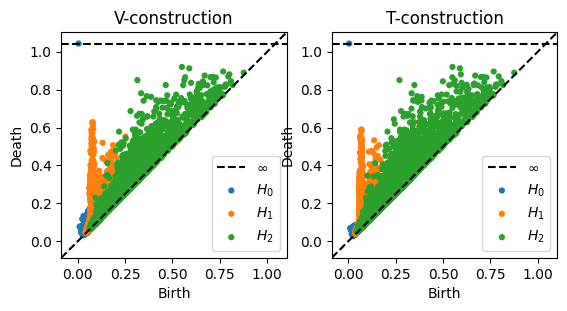

In [ ]:
# sublevel filtration of the original image (pixel value filtration)
# V-construction
pd = cripser.computePH(img3d)
pds = [pd[pd[:,0] == i] for i in range(3)]
print("Betti numbers: ",[len(pds[i]) for i in range(len(pds))])

# T-construction of the original image (pixel value filtration)
pdt = tcripser.computePH(img3d)
pdst = [pdt[pdt[:,0] == i] for i in range(3)]
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])

## plot persistent diagram using persim
fig,axs = plt.subplots(1,2)
persim.plot_diagrams([p[:,1:3] for p in pds], ax=axs[0], title='V-construction')
persim.plot_diagrams([p[:,1:3] for p in pdst], ax=axs[1], title='T-construction')


In [ ]:
%%timeit -r 3
# compute PH for the T-construction by GUDHI
gd = gudhi.CubicalComplex(top_dimensional_cells=img3d)
#gd = gudhi.CubicalComplex(vertices=img)
#    gd.compute_persistence()
res = gd.persistence(2,0) # coeff = 2
print("Betti numbers: ", gd.persistent_betti_numbers(np.inf,-np.inf))


Betti numbers:  [25798, 97689, 64399, 0]
Betti numbers:  [25798, 97689, 64399, 0]
Betti numbers:  [25798, 97689, 64399, 0]
Betti numbers:  [25798, 97689, 64399, 0]
12 s ± 646 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
%%timeit -r 3
# compute PH for the T-construction by CubicalRipser
pdt = tcripser.computePH(img3d, fortran_order=True)
pdst = [pdt[pdt[:,0] == i] for i in range(3)]
print("Betti numbers: ",[len(pdst[i]) for i in range(len(pdst))])


Betti numbers:  [25798, 97689, 64399]
Betti numbers:  [25798, 97689, 64399]
Betti numbers:  [25798, 97689, 64399]
Betti numbers:  [25798, 97689, 64399]
3.7 s ± 270 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


### Time series
Time series is a 1D image so basically the techniques in the previous section apply straightforwardly.
Here, we see examples with different tasks.

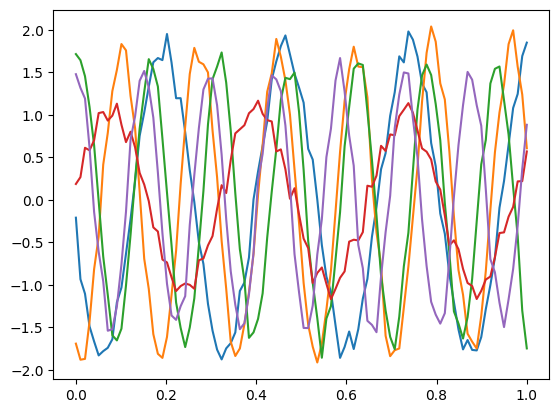

In [ ]:
# synthetic example:
# Goal: to infer the period of sine curve from noisy data
n=200  # number of samples
t = np.linspace(0,1,100)
a=np.random.uniform(low=1,high=2,size=n)  # amplitude
b=np.random.uniform(low=1.5,high=7,size=n) # period <= our target for regression
c=np.random.uniform(low=-np.pi,high=np.pi,size=n) # phase
# create different sine curves with noise
X = [a[i]*np.sin(2*np.pi*b[i]*t+c[i]) + np.random.normal(scale=0.1,size=len(t)) for i in range(n)]
for i in range(5):
    plt.plot(t,X[i])

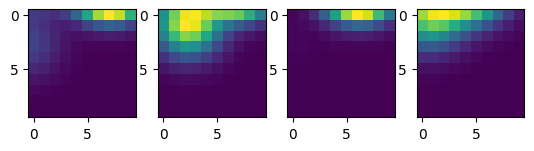

In [ ]:
## compute PH and vectorise by persistence image
import persim,cripser
import PersistenceImages.persistence_images as pimg

#pim=persim.PersImage(pixels=[10,10], spread=1) ## for persim
pim = pimg.PersistenceImager(birth_range=(0,5), pers_range=(0,5), pixel_size=0.5)
#print(pim)
pds, pims = [], []
for i in range(len(X)):
    pd = cripser.computePH(X[i])[:,1:3]    # compute PH
    pds.append(np.clip(pd,a_min=-2,a_max=2))  # clip min/max birth/death
    pims.append(pim.transform(pds[i])) # vectorise by persistence image
for i in range(4):   # plot persistence images for the first four samples
    ax = plt.subplot(240+i+1)
    ax.imshow(pims[i])
    #pim.show(pims[i], ax) ## for persim

MSE train : 0.149, test : 0.211
R2 train : 0.940, test : 0.918


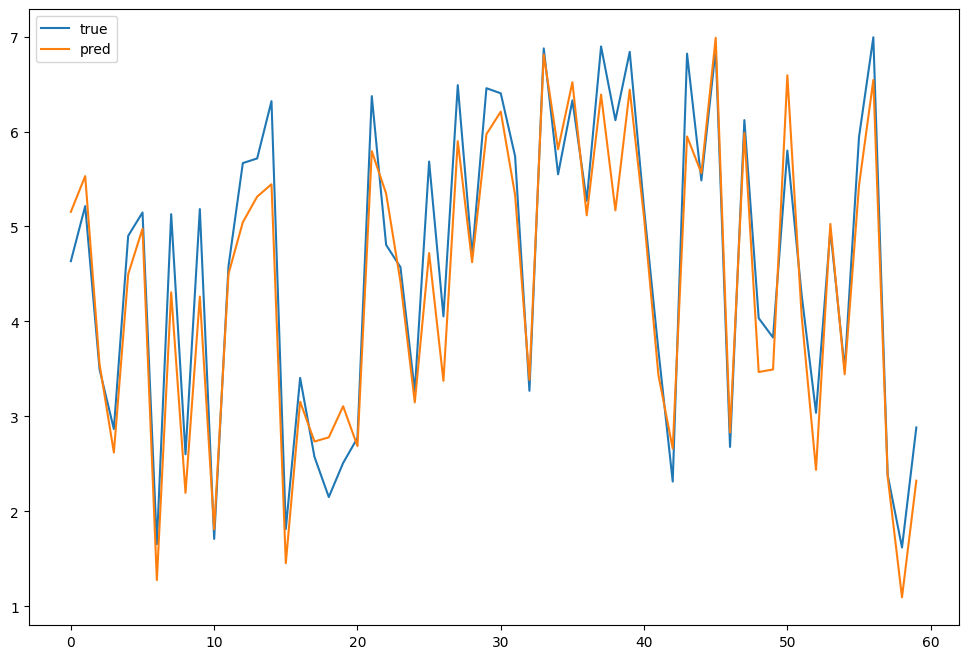

In [ ]:
# linear regression for the period: Input: PH of time series => Output: period
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

# train-test split
(trainX, testX, trainY, testY) = train_test_split(np.array(pims).reshape(n,-1), b, test_size = 0.3, random_state = 0) # use PH features

# fit model
clf = linear_model.Lasso(alpha=0.0001,max_iter=10000)
clf.fit(trainX, trainY)

# prediction: the result is reasonably good
trainPred = clf.predict(trainX)
testPred = clf.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

plt.figure(figsize=(12,8))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

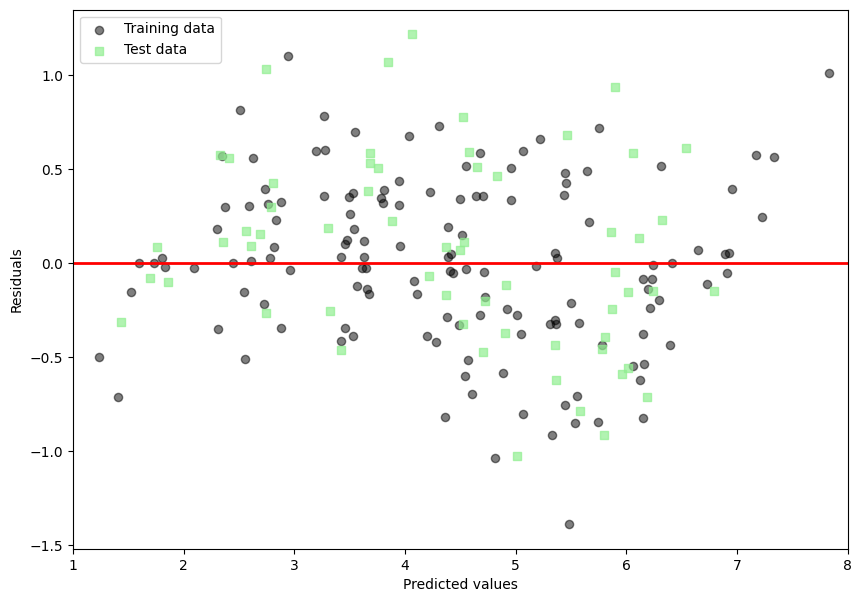

In [ ]:
# residual plot
plt.figure(figsize = (10, 7))
plt.scatter(trainPred, trainPred - trainY, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.scatter(testPred, testPred - testY, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 1, xmax = 8, lw = 2, color = 'red')
plt.xlim([1, 8])
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.958e+00, tolerance: 3.476e-02
  model = cd_fast.enet_coordinate_descent(


MSE train : 0.604, test : 7.863
R2 train : 0.757, test : -2.053


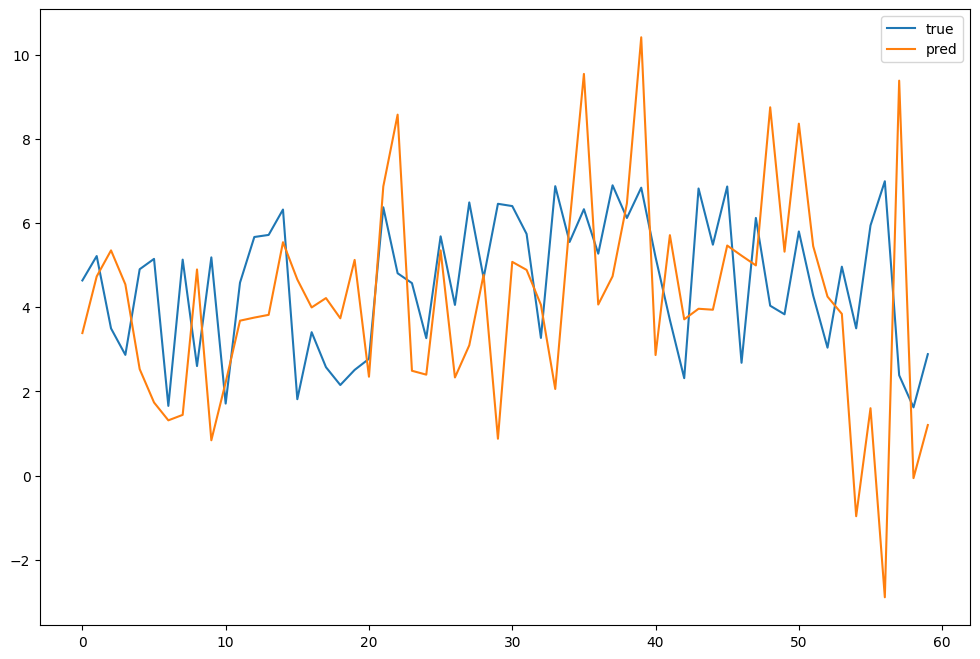

In [ ]:
## If we use the original data directly instead of PH, the result is worse
# Input: original time series => Output: period

(trainX, testX, trainY, testY) = train_test_split(X, b, test_size = 0.3, random_state = 0)  # see what happens if we use the input data directly

# fit model
clf = linear_model.Lasso(alpha=0.0001,max_iter=10000)
clf.fit(trainX, trainY)

# prediction: the result is much worse!
trainPred = clf.predict(trainX)
testPred = clf.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

plt.figure(figsize=(12,8))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

MSE train : 0.401, test : 0.370
R2 train : 0.839, test : 0.856


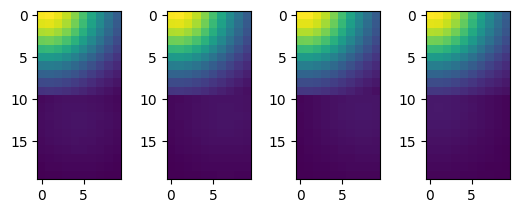

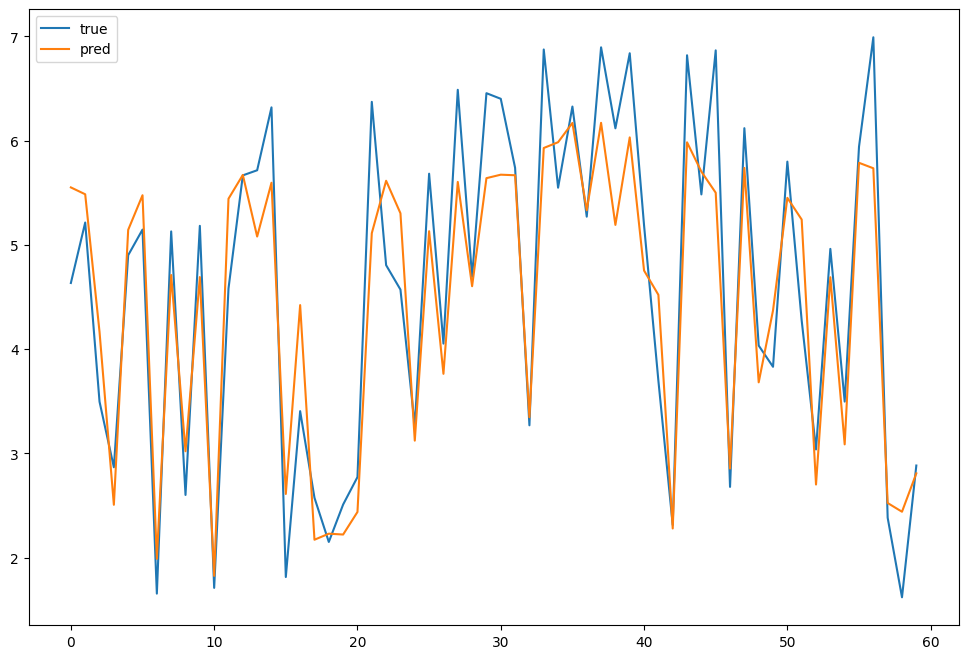

In [ ]:
# Instead of directly computing PH of the time series as a function over the real line,
# we can use Takens' embedding to first convert the time series into a geometric object (approximated attractor)
# and look at its topological features by PH. The result is not so good in this particular case.
# Input: Takens' embedded time series => Output: period

import gudhi.point_cloud.timedelay
embedder = gudhi.point_cloud.timedelay.TimeDelayEmbedding(dim=2, delay=3, skip=1)
X_takens = embedder.transform(X)

pim = pimg.PersistenceImager(birth_range=(0,2), pers_range=(0,2), pixel_size=0.2)
pds, pims = [], []
for i in range(len(X)):
    pd = ripser(X_takens[i])['dgms']    # compute PH
    pim0 = pim.transform(np.clip(pd[0],a_min=0,a_max=2)) #PH_0
    pim1 = pim.transform(np.clip(pd[1],a_min=0,a_max=2)) #PH_1
    pims.append(np.concatenate([pim0,pim1])) # combine PH_0 and PH_1 to make a feature vector
for i in range(4):   # plot persistence images
    ax = plt.subplot(240+i+1)
    ax.imshow(pims[i])
    #pim.show(pims[i], ax) ## for persim

## linear regression fot the period
# train-test split
(trainX, testX, trainY, testY) = train_test_split(np.array(pims).reshape(n,-1), b, test_size = 0.3, random_state = 0) # use PH features

# fit model
clf = linear_model.Lasso(alpha=0.0001,max_iter=10000)
clf.fit(trainX, trainY)

# prediction: the result is worse than without embedding.
# This is reasonable; because with the direct signal, 0-th betti number corresponds to the frequency.
# Takens' embedding is useful when dealing with signals coming from deterministic dynamical systems,
# as the embedding reconstructs the attractors of the systems.

trainPred = clf.predict(trainX)
testPred = clf.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

plt.figure(figsize=(12,8))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

MSE train : 0.063, test : 0.691
R2 train : 0.975, test : 0.732


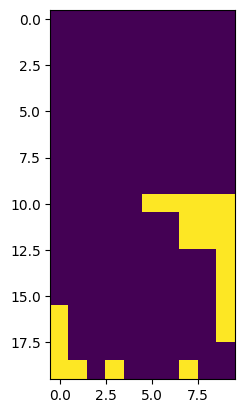

In [ ]:
## non-linear feature selection with RandomForest (this takes a little time)
## Locate which entries in Persistence Image have a large impact in the prediction.
## This tells cycles in what range of birh and life are important for the current task at hand.

from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

(trainX, testX, trainY, testY) = train_test_split(np.array(pims).reshape(n,-1), b, test_size = 0.3, random_state = 0) # use PH features

# feature selection with Boruta: takes a few minutes
rf = RandomForestRegressor(n_jobs=-1,n_estimators=50,max_depth=15)
feat_selector = BorutaPy(rf, verbose=0)
feat_selector.fit(trainX, trainY)
#print(feat_selector.ranking_)

X_filtered = feat_selector.transform(trainX)
rf.fit(X_filtered, trainY)
trainPred = rf.predict(X_filtered)
testPred = rf.predict(feat_selector.transform(testX))
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )

# plot selected region in persistent image
plt.imshow(feat_selector.support_.reshape(pims[0].shape))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 9s 84ms/step - loss: 21.1034 - val_loss: 22.0744
Epoch 2/100
7/7 [==============================] - 0s 17ms/step - loss: 15.3540 - val_loss: 3.0242
Epoch 3/100
7/7 [==============================] - 0s 15ms/step - loss: 2.7753 - va

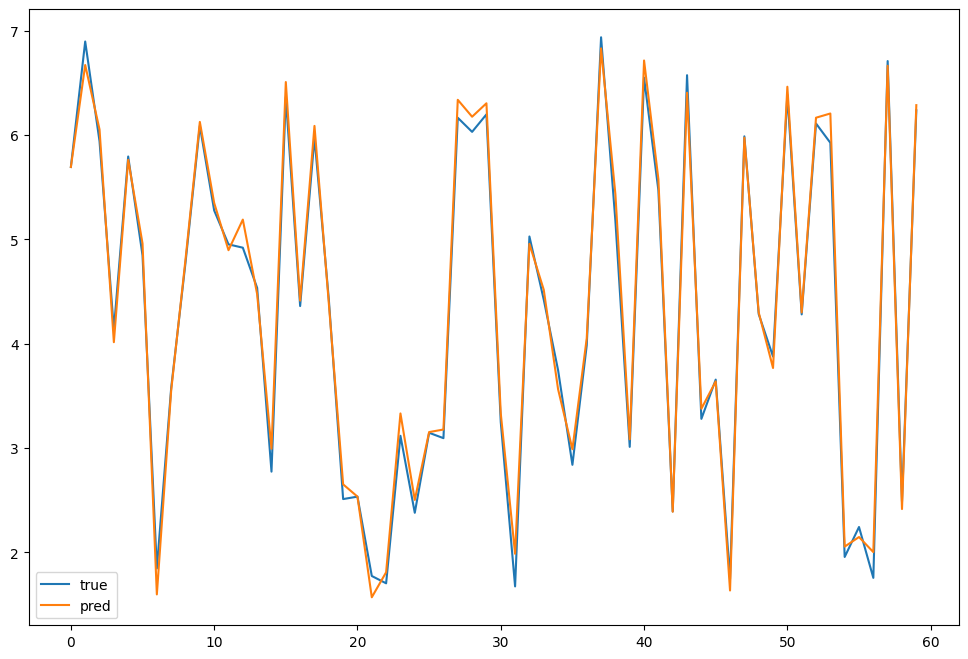

In [ ]:
## Let's compare the performance with LSTM (a popular version of recurrent neural network)
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# train-test split
(trainX, testX, trainY, testY) = train_test_split(np.array(X).reshape(n,-1,1), b, test_size = 0.3, random_state = 0)

# LSTM model definition
num_hidden_units = 128
model = Sequential()
model.add(LSTM(
    num_hidden_units,
    input_shape=(len(t), 1),
    return_sequences=False))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))
model.summary()

# train
model.fit(trainX, trainY, batch_size=20, epochs=100,
    validation_split=0.1,   ## isn't it unfair?
    callbacks=[EarlyStopping(monitor='val_loss', mode='auto', patience=50)]
)

# prediction: LSTM performs better
trainPred = model.predict(trainX)
testPred = model.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )
plt.figure(figsize=(12,8))
plt.plot(testY,label="true")
plt.plot(testPred, label="pred")
plt.legend()
plt.show()

## Dimension reduction
Dimension reduction techniques can be used for
- Visualisation
- as a preprocess for regressor/classifier
- outlier detection

(901, 64)


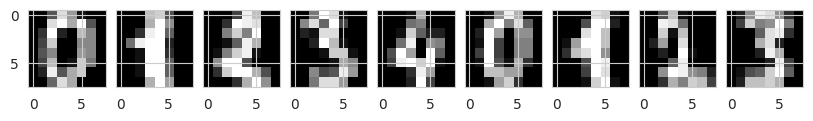

In [ ]:
# load demo data: hand written digits
import sklearn
import sklearn.datasets
from scipy import stats
from sklearn import manifold
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import ImageGrid
# seaborn makes matplot drawing charming
import seaborn as sns
sns.set_style("whitegrid")

X,Y = sklearn.datasets.load_digits(n_class=5,return_X_y=True)
print(X.shape)
num_disp=9
fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111,nrows_ncols=(1, num_disp),axes_pad=0.1)
for ax,x in zip(grid, X[:num_disp]):
    ax.imshow(x.reshape(8,8),cmap="gray")


### Visualisation

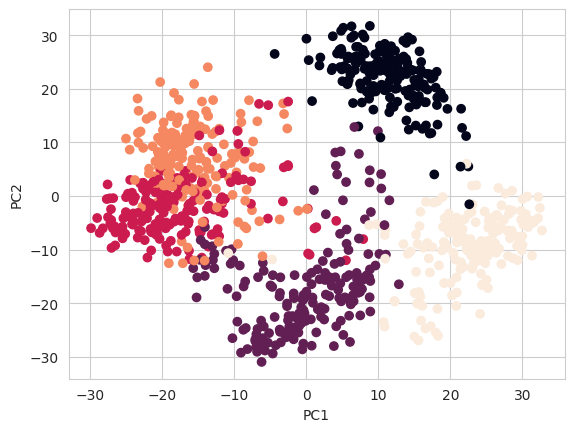

In [ ]:
## everyone's favourite PCA: indeed, it is not so bad though there are some overlaps among different classes (indicated by the point colour)
pca = PCA(n_components=3)
X_pca = pca.fit(X).transform(X)
# plot first and second primary components
plt.scatter(X_pca[:,0],X_pca[:,1],c=Y)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

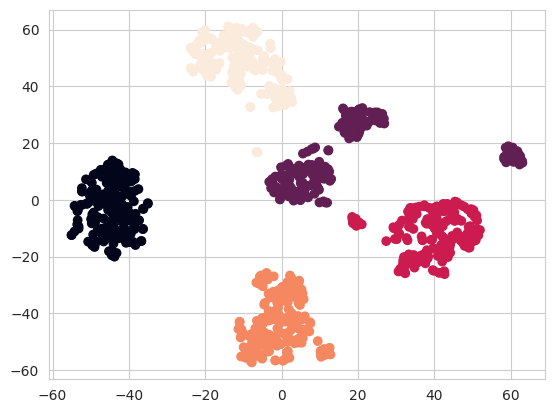

In [ ]:
# t-SNE: one of the most popular method. Excellent for preprocess but the meaning of the components are less clear
X_tsne = manifold.TSNE(n_components=2,perplexity=20).fit_transform(X)
plt.scatter(X_tsne[:,0],X_tsne[:,1],c=Y)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


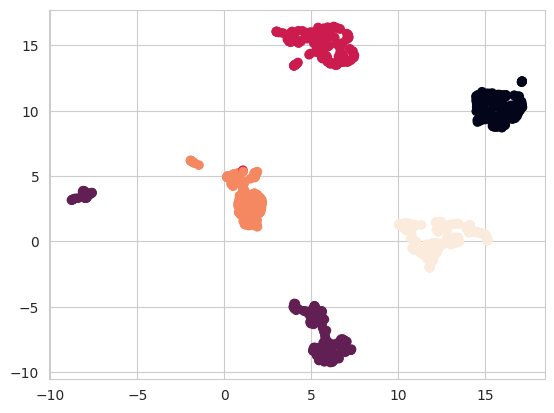

In [ ]:
# Universal Manifold Learning (umap): projects vectors while keeping the topology
import umap
X_umap = umap.UMAP(n_components=2, n_neighbors=5, metric='euclidean').fit_transform(X)
plt.scatter(X_umap[:,0],X_umap[:,1],c=Y)

In [ ]:
## Mapper: good for revealing rich topology but difficult to tune
# the visualisation does not work with Google Colab. Please use Jupyter-notebook
import kmapper, kmapper.jupyter
from sklearn.preprocessing import StandardScaler
import networkx as nx

km = kmapper.KeplerMapper()
X_std = StandardScaler().fit_transform(X)   # standardise
f = km.project(X_std,projection="sum") # we have to choose a 1-dim projection
graph = km.map(lens=f, X=X_std, clusterer=sklearn.cluster.DBSCAN(metric="cosine",algorithm='auto', eps=0.3, leaf_size=10))
nx.draw(kmapper.adapter.to_nx(graph))
km.visualize(graph, color_function=Y, custom_tooltips=Y, path_html="kepler-mapper-output.html") # To download the output, look at the beginning of this note
print("Download kepler-mapper-output.html and open it with a browser to see the results.")
# the following rich visualisation does not work with Google Colab.
# download "kepler-mapper-output.html" and open it locally with a browser
#kmapper.jupyter.display(path_html="kepler-mapper-output.html")

### Classification

In [ ]:
## classification with Randomforest
# first, directly with the vector data (image pixel values)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# train-test split
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.3, random_state = 0)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)

# classification results
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,classification_report
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))

Confusion matrix
 [[52  0  0  0  0]
 [ 0 51  2  5  3]
 [ 0  2 54  3  0]
 [ 0  1  3 47  1]
 [ 1  0  0  0 46]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       0.94      0.84      0.89        61
           2       0.92      0.92      0.92        59
           3       0.85      0.90      0.88        52
           4       0.92      0.98      0.95        47

    accuracy                           0.92       271
   macro avg       0.92      0.93      0.92       271
weighted avg       0.92      0.92      0.92       271



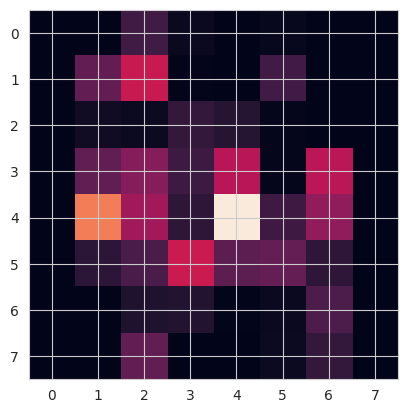

In [ ]:
## identify what variables have impact on the decision
# in this case, which pixels are important to distinguish digits
indices = np.argsort(clf.feature_importances_)
#plt.barh(range(len(indices)), clf.feature_importances_[indices])
plt.imshow(clf.feature_importances_.reshape(8,8))

In [ ]:
## Now, first dimension reduction (64 -> 5) and classify
# You'll observe the accuracy gets better!
X_umap = umap.UMAP(n_components=5, n_neighbors=5, metric='euclidean').fit_transform(X)
(trainX, testX, trainY, testY) = train_test_split(X_umap, Y, test_size = 0.3, random_state = 0)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))

Confusion matrix
 [[52  0  0  0  0]
 [ 0 61  0  0  0]
 [ 0  0 59  0  0]
 [ 0  0  0 52  0]
 [ 0  0  0  0 47]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00        52
           4       1.00      1.00      1.00        47

    accuracy                           1.00       271
   macro avg       1.00      1.00      1.00       271
weighted avg       1.00      1.00      1.00       271



In [ ]:
## for comparison, use persistence image as a feature extractor and do classification
# We see it is insufficient to look at PH in this case; only digit 0 can be classified with a reasonable accuracy
# It is VERY important to understand that TDA does not replace conventional methods.
# In fact, TDA is usually much weaker when used alone. Therefore, TDA should be used as a complementary analysis technique.
pim = pimg.PersistenceImager(birth_range=(0,3), pers_range=(0,3), pixel_size=0.5)
pds, pims_h0, pims_h1 = [], [], []
for i in range(len(X)):
    img = X[i].reshape(8,8)
    bw_img = (img >= threshold_otsu(img))
    dt_img = distance_transform_edt(~bw_img)
    pd = cripser.computePH(dt_img)    # compute PH of distance transform
    pd[:,1:3] = np.clip(pd[:,1:3],a_min=0,a_max=3) # clip min/max birth/death
    pds.append(pd)
    pim0 = pim.transform(pd[pd[:,0]==0,1:3])
    pim1 = pim.transform(pd[pd[:,0]==1,1:3])
    pims_h0.append(pim0.ravel()) # vectorise by persistence image
    pims_h1.append(pim1.ravel()) # vectorise by persistence image

(trainX, testX, trainY, testY) = train_test_split(pims_h1, Y, test_size = 0.3, random_state = 0)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))


Confusion matrix
 [[43  0  0  9  0]
 [ 0  0  0 61  0]
 [ 0  0  0 59  0]
 [ 1  0  0 51  0]
 [ 5  0  0 42  0]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        52
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        59
           3       0.23      0.98      0.37        52
           4       0.00      0.00      0.00        47

    accuracy                           0.35       271
   macro avg       0.22      0.36      0.24       271
weighted avg       0.21      0.35      0.23       271



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Clustering

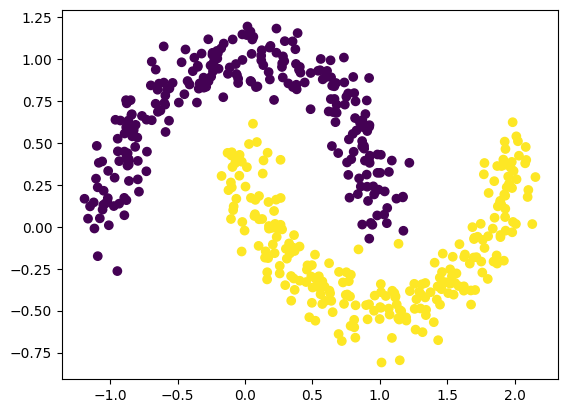

In [ ]:
## ToMATo (Topological Mode Analysis Tool)
# an interesting and less-known application of persistent homology is to clustering.
# input: graph with real values on vertices => clustering for vertices
import tomaster
import sklearn.datasets
X,_ = sklearn.datasets.make_moons(n_samples=500, noise=0.1)
clusters = tomaster.tomato(points = X, k=10, n_clusters=2)
plt.scatter(*X.T, c=clusters)
# Compare the results in https://scikit-learn.org/stable/modules/clustering.html

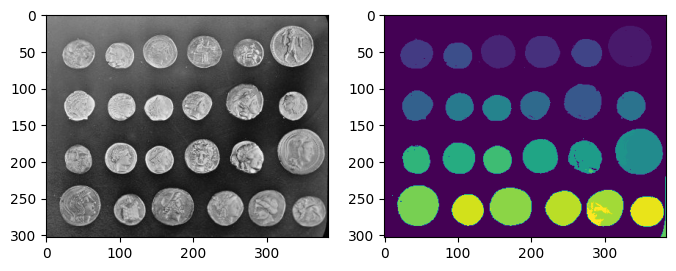

In [ ]:
## ToMaTo applied for image segmentation
# just for demonstration: there are better ways for ordinary segmentation tasks.
import skimage
img = skimage.data.coins()
clusters = tomaster.tomato_img(img, spatial_weight=1, k=10, n_clusters=30)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(img,cmap='gray')
ax = fig.add_subplot(122)
ax.imshow(clusters)
